In [1]:
import os, sys

def get_dir_n_levels_up(path, n):
    # Go up n levels from the given path
    for _ in range(n):
        path = os.path.dirname(path)
    return path


proj_root = get_dir_n_levels_up(os.path.abspath("__file__"), 4)
sys.path.append(proj_root)

print(proj_root)

d:\Work\repos\RL\phd-rl-algos


In [2]:
import numpy as np
from rl_envs_forge.envs.network_graph.network_graph import NetworkGraph

from dqn.opinion_dynamics.utils.experiment import build_environment

from dynamic_programming.opinion_dynamics.algos import compute_average_error, compute_final_average_error, generate_full_control_policy
from dynamic_programming.opinion_dynamics.algo_infinite_horizon import value_iteration, extract_policy, create_state_grid
from dynamic_programming.opinion_dynamics.common.viz import plot_opinions_over_time, visualize_policy_from_env


In [3]:

def run_policy(env, policy, nx, step_duration, max_steps=1000):
    """
    Run the simulation using a given policy with a maximum number of steps.

    Args:
        env: The environment with network properties.
        policy: The control policy to be used.
        nx: Number of grid points per dimension (used for mapping states to grid indices).
        step_duration: Duration of each policy application.
        tolerance: Tolerance for the mean opinion to stop the simulation.
        max_steps: Maximum number of steps to run.

    Returns:
        opinions_over_time: Array of opinions over the entire simulation.
        time_points: Corresponding time points for each opinion snapshot.
        rewards_over_time: Collected rewards at each step.
    """
    N = env.num_agents
    opinions_over_time = []
    time_points = []
    rewards_over_time = []
    current_time = 0.0
    state, _ = env.reset()
    grids = create_state_grid(N, nx)

    for step in range(max_steps):
        idx = tuple(np.abs(grids[i] - state[i]).argmin() for i in range(N))
        action = policy.get(idx, np.zeros(N))
        
        print(action)
        next_state, reward, done, truncated, _ = env.step(action, env.tau)
        
        opinions_over_time.append(next_state.copy())
        rewards_over_time.append(reward)
        time_points.append(current_time)
        # print(f"Step: {step}, Time: {current_time}, Reward: {reward}")
        
        current_time += step_duration
        state = next_state

        if done or truncated:
            print(f"Ran for {step} steps: done={done}, truncated={truncated}")
            break
        
    return np.array(opinions_over_time), np.array(time_points), np.array(rewards_over_time)


[0.5 0.5 0.5 0.5]
[0.5 0.5 0.5 0.5]
[0.5 0.5 0.5 0.5]
[0.5 0.5 0.5 0.5]
[0.5 0.5 0.5 0.5]
[0.5 0.5 0.5 0.5]
Ran for 5 steps: done=True, truncated=False


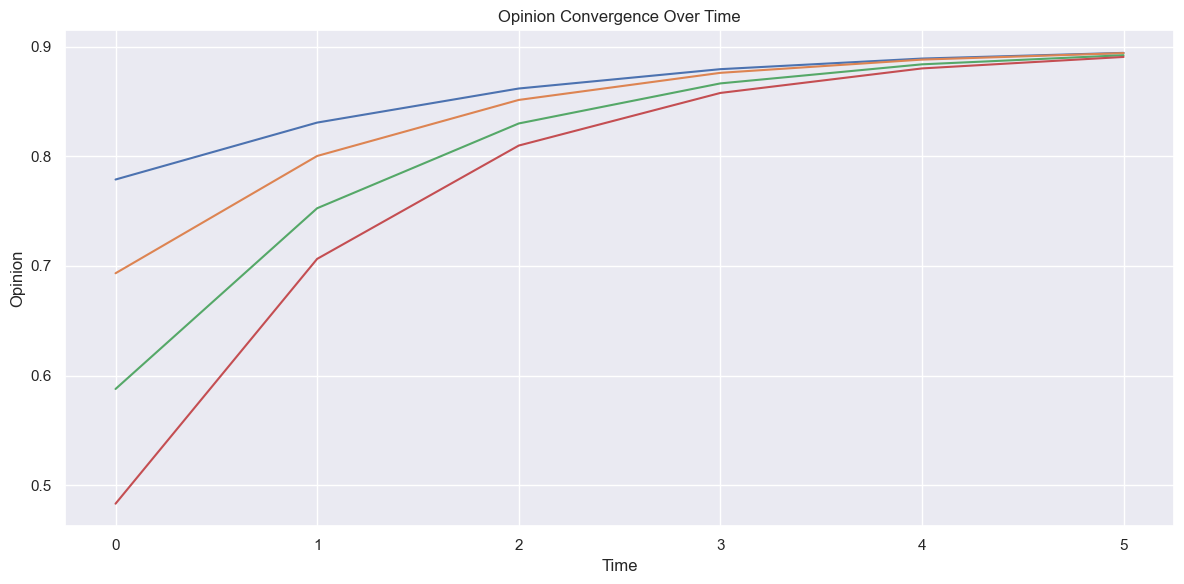

In [4]:
env = build_environment()
num_steps = 50
nx = 5

policy_broadcast = generate_full_control_policy(env, nx)

opinions_over_time, time_points, rewards = run_policy(env, policy_broadcast, nx=nx, step_duration=env.tau, max_steps=num_steps)
plot_opinions_over_time(opinions_over_time)

In [5]:
env = build_environment()

# Adjusted parameters
beta = 0.4
gamma = 0.9
step_duration = env.tau
nx = 5 

V = value_iteration(env, nx=nx, gamma=gamma, beta=beta, step_duration=step_duration)
policy = extract_policy(
    env, V, nx=nx, gamma=gamma, beta=beta, step_duration=step_duration
)
    

Converged in 124 iterations.


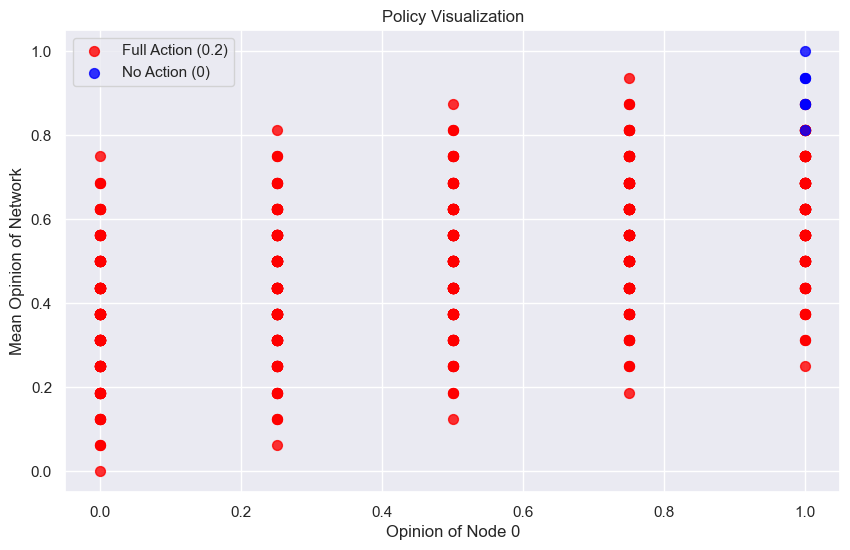

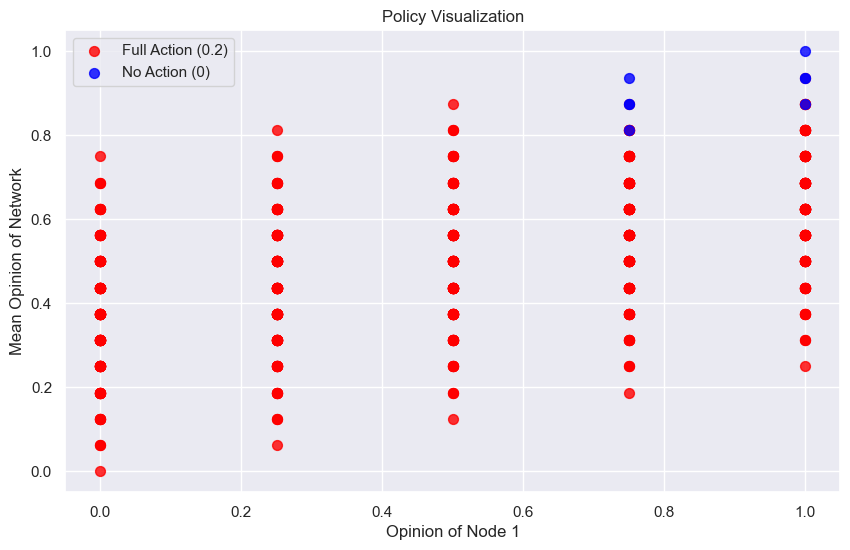

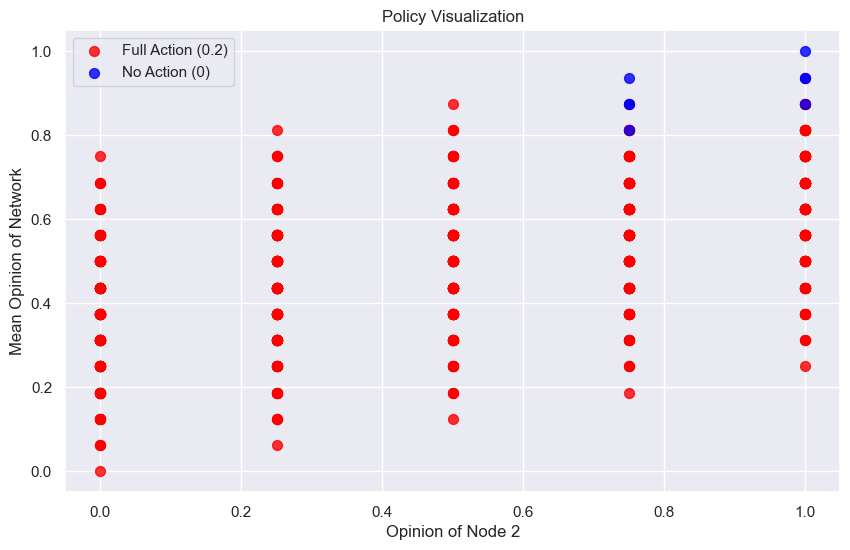

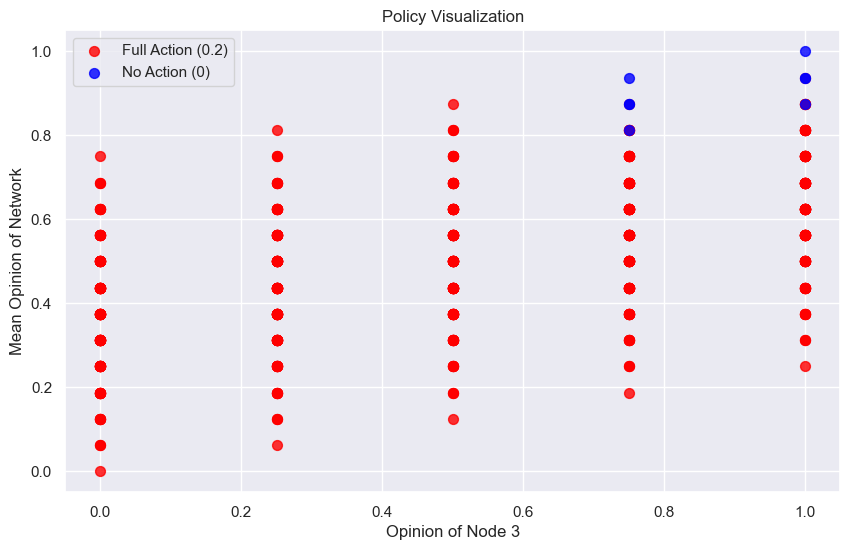

In [6]:
for node_index in range(env.num_agents):
    visualize_policy_from_env(policy, env, nx=nx, node_index=node_index)